# Collaboration and Competition

---

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python
from unityagents import UnityEnvironment
import numpy as np
from collections import deque

import random
import torch

import matplotlib.pyplot as plt
%matplotlib inline


tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.4 which is incompatible.


1. Download the environment from one of the links below.  You need only select the environment that matches your operating system:
    - Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip)
    - Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis.app.zip)
    - Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86.zip)
    - Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86_64.zip)
    
Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`


In [2]:
env = UnityEnvironment(file_name='/data/Tennis_Linux_NoVis/Tennis')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Defining Maddpg and Plotting functions



In [5]:
# Define a training function
def maddpg(n_episodes=2000, max_t=1000):
    """Multi-Agent Deep Deterministic Policy Gradient Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores_deque = deque(maxlen=100)
    scores_total = []
    average_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment
        states = env_info.vector_observations                   # get the current state
        agent.reset()                                           # reset the agent noise
        scores = np.zeros(num_agents)                           # initialize the score
        for t in range(max_t):
            actions = agent.act(states)                         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states                                # roll over to next time step
            scores += rewards                                   # update the score
            if np.any(dones):                                   # exit loop if episode done
                break 
        scores_deque.append(np.max(scores))                     # save most recent score
        scores_total.append(np.max(scores))                     # save most recent score
        average_scores.append(np.mean(scores_deque))            # save most recent average score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores_total, average_scores

In [6]:

# Define a plotting function
def plot_scores(scores, average_scores, title):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, alpha=0.5)
    plt.plot(np.arange(len(scores)), average_scores, linewidth=1.5, c='r')
    plt.ylabel('Score')
    plt.xlabel('Episode ')
    plt.title(title)
    plt.savefig('scores_plot.png')
    plt.show()
    return fig

### 4. Create Agent for Training:

    

```python
env_info = env.reset(train_mode=True)[brain_name] # train_mode True eables the environment for training
```

Episode 100	Average Score: 0.05
Episode 200	Average Score: 0.29
Episode 300	Average Score: 0.38
Episode 318	Average Score: 0.52
Environment solved in 218 episodes!	Average Score: 0.52
CPU times: user 13min 41s, sys: 42.1 s, total: 14min 23s
Wall time: 15min 5s


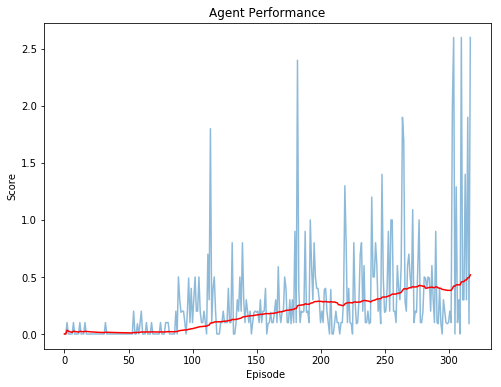

In [7]:
# Import and define MADDPG agent
from MADDPG.maddpg_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=1)

# Train deep deterministic policy gradient agents
%time scores, average_scores = maddpg()

# Plot the scores
figure = plot_scores(scores, average_scores, 'Agent Performance')

In [8]:
env.close()
